In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import seaborn as sns
import folium
%matplotlib inline

In [2]:
data = pd.read_csv('pos_Lon_Lat_x_y_date_normal.csv',index_col=0)

In [186]:
data_distance = pd.read_csv('bee_pos_distance_date.csv',index_col=0)
data_distance['Date Normal'] = data['Date Normal']

KeyError: 'Date Normal'

In [30]:
import math
import random
import string
 
random.seed(0)
 
# 生成区间[a, b)内的随机数
def rand(a, b):
    return (b-a)*random.random() + a
 
# 生成大小 I*J 的矩阵，默认零矩阵 (当然，亦可用 NumPy 提速)
def makeMatrix(I, J, fill=0.0):
    m = []
    for i in range(I):
        m.append([fill]*J)
    return m
 
# 函数 sigmoid，这里采用 tanh，因为看起来要比标准的 1/(1+e^-x) 漂亮些
def sigmoid(x):
    return math.tanh(x)
 
# 函数 sigmoid 的派生函数, 为了得到输出 (即：y)
def dsigmoid(y):
    return 1.0 - y**2
 
class NN:
    ''' 三层反向传播神经网络 '''
    def __init__(self, ni, nh, no):
        # 输入层、隐藏层、输出层的节点（数）
        self.ni = ni + 1 # 增加一个偏差节点
        self.nh = nh
        self.no = no
 
        # 激活神经网络的所有节点（向量）
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no
        
        # 建立权重（矩阵）
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)
        # 设为随机值
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-0.2, 0.2)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-2.0, 2.0)
 
        # 最后建立动量因子（矩阵）
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)
 
    def update(self, inputs):
        if len(inputs) != self.ni-1:
            raise ValueError('与输入层节点数不符！')
 
        # 激活输入层
        for i in range(self.ni-1):
            #self.ai[i] = sigmoid(inputs[i])
            self.ai[i] = inputs[i]
 
        # 激活隐藏层
        for j in range(self.nh):
            sum = 0.0
            for i in range(self.ni):
                sum = sum + self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(sum)
 
        # 激活输出层
        for k in range(self.no):
            sum = 0.0
            for j in range(self.nh):
                sum = sum + self.ah[j] * self.wo[j][k]
            self.ao[k] = sigmoid(sum)
 
        return self.ao[:]
 
    def backPropagate(self, targets, N, M):
        ''' 反向传播 '''
        if len(targets) != self.no:
            raise ValueError('与输出层节点数不符！')
 
        # 计算输出层的误差
        output_deltas = [0.0] * self.no
        for k in range(self.no):
            error = targets[k]-self.ao[k]
            output_deltas[k] = dsigmoid(self.ao[k]) * error
 
        # 计算隐藏层的误差
        hidden_deltas = [0.0] * self.nh
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error = error + output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error
 
        # 更新输出层权重
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k]*self.ah[j]
                self.wo[j][k] = self.wo[j][k] + N*change + M*self.co[j][k]
                self.co[j][k] = change
                #print(N*change, M*self.co[j][k])
 
        # 更新输入层权重
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] = self.wi[i][j] + N*change + M*self.ci[i][j]
                self.ci[i][j] = change
 
        # 计算误差
        error = 0.0
        for k in range(len(targets)):
            error = error + 0.5*(targets[k]-self.ao[k])**2
        return error
 
    def test(self, patterns):
        for p in patterns:
            print(p[0], '->', self.update(p[0]))
 
    def weights(self):
        print('输入层权重:')
        for i in range(self.ni):
            print(self.wi[i])
        print()
        print('输出层权重:')
        for j in range(self.nh):
            print(self.wo[j])
 
    def train(self, patterns, iterations=10000, N=0.5, M=0.1):
        # N: 学习速率(learning rate)
        # M: 动量因子(momentum factor)
        for i in range(iterations):
            error = 0.0
            for p in patterns:
                inputs = p[0]
                targets = p[1]
                self.update(inputs)
                error = error + self.backPropagate(targets, N, M)
            if i % 100 == 0:
                print('误差 %-.5f' % error)
 
 
def demo():
    # 一个演示：教神经网络学习逻辑异或（XOR）------------可以换成你自己的数据试试
    # pat = [
    #     [[0,0], [1]],
    #     [[0,1], [0]],
    #     [[1,0], [0]],
    #     [[1,1], [1]]
    # ]
    pat = []
 
    for i in range(7):
        # pat.append([[i],[i+1]])
        pat.append([[float(data_distance['Detection Num'][i])],[int(data_distance['Distance'][i])]])
    # 创建一个神经网络：输入层有两个节点、隐藏层有两个节点、输出层有一个节点
    n = NN(1, 10, 1)
    # 用一些模式训练它
    n.train(pat)
    # 测试训练的成果（不要吃惊哦）
    n.test(pat)
    # 看看训练好的权重（当然可以考虑把训练好的权重持久化）
    
    n.weights()
    
    
if __name__ == '__main__':
    demo()

误差 4784.41174
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 4616.50000
误差 461

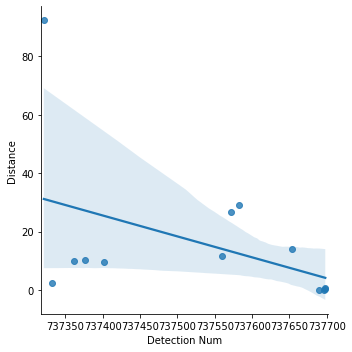

In [13]:
sns.lmplot(x='Detection Num',y='Distance',data=data_distance)
plt.show()

In [36]:
from statsmodels.tsa.stattools import adfuller
df1 = data_distance.resample('D',how='mean')
#[['Detection Date','Distance']]
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df1.Spend.dropna())

TypeError: resample() got an unexpected keyword argument 'how'

In [40]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
 
# def parser(x):
#     return datetime.strptime('190'+x, '%Y-%m')
# series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

data_distance['Detection Date'] = pd.to_datetime(data_distance['Detection Date'])
autocorrelation_plot(data_distance['Detection Date'])
pyplot.show()

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

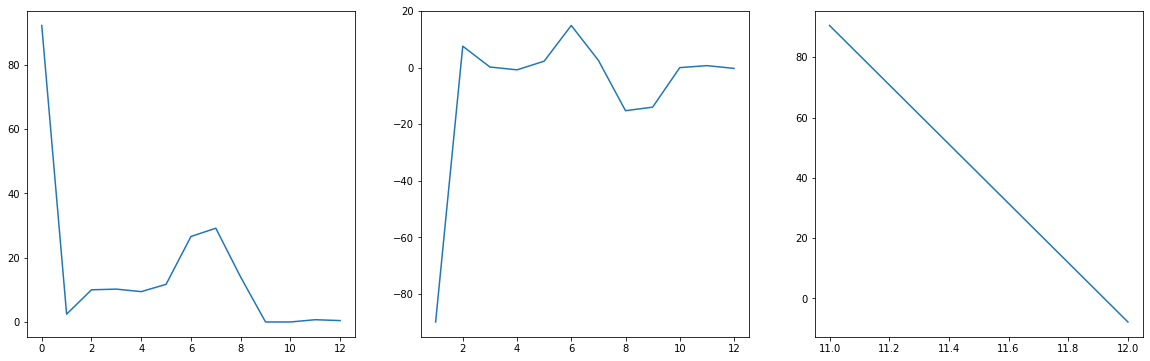

In [45]:
data_distance['Close_diff_1'] = data_distance['Distance'].diff(1)
data_distance['Close_diff_10'] = data_distance['Close_diff_1'].diff(10)
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(131)
ax1.plot(data_distance['Distance'])
ax2 = fig.add_subplot(132)
ax2.plot(data_distance['Close_diff_1'])
ax3 = fig.add_subplot(133)
ax3.plot(data_distance['Close_diff_10'])
plt.show()

In [48]:

from statsmodels.tsa.arima_model import ARMA
import statsmodels as sm
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
 
if __name__ == '__main__':
    mpl.rcParams['font.sans-serif'] = 'SimHei'
    mpl.rcParams['axes.unicode_minus'] = False
    # data=pd.read_csv('AirPassengers.csv',header=0,names=['date','peo_num'])
    data = data_distance.copy()
    data = pd.Series(data["Distance"].values, \
                           index=data["Detection Date"].values)
    decomposition=seasonal_decompose(data,model='additive')
    trend=decomposition.trend
    seasonal=decomposition.seasonal
    residual=decomposition.resid
    #对三部分分别进行拟合
    trend.dropna(inplace=True)
    trend_diff=trend.diff(periods=2)
    trend_diff.dropna(inplace=True)
    #分别对三部分进行拟合z
    order_trend=sm.tsa.stattools.arma_order_select_ic(trend_diff)['bic_min_order']
    #order_trend=(3,2)
    model_trend=ARMA(trend_diff,order_trend)
    result_trend=model_trend.fit()
    predict_trend=result_trend.predict()+trend.shift(2)
    forecast_trend,_,_=result_trend.forecast(11)
    forecast_trend=pd.Series(forecast_trend,\
                             index=pd.DatetimeIndex(start='2021-07-01',end='2021-05-01'))
    trend_predict=pd.concat([predict_trend,forecast_trend],axis=0)
    for i in range(11,0,-1):
        trend_predict.values[-i]+=trend_predict[-i-2]
    value_seasonal=[]
    for i in range(5):
        value_seasonal.append(seasonal.values[i])
    forecast_seasonal=pd.Series(value_seasonal,\
                                index=pd.DatetimeIndex(start='2021-01-01',end='2021-05-01'))
    seasonal_predict=pd.concat([seasonal,forecast_seasonal],axis=0)
 
    residual.dropna(inplace=True)
    order_residual=sm.tsa.stattools.arma_order_select_ic(residual)['bic_min_order']
    model_residual=ARMA(residual,order_residual)
    result_residual=model_residual.fit()
    predict_residual=result_residual.predict()
    forecast_residual,_,_=result_residual.forecast(11)
    forecast_residual=pd.Series(forecast_residual,\
                                index=pd.DatetimeIndex(start='2021-07-01',end='2021-05-01'))
    residual_predict=pd.concat([predict_residual,forecast_residual],axis=0)
    test_data=trend_predict+seasonal_predict+residual_predict
    print(test_data)
    data.plot(label='train_data',legend=True)
    test_data.plot(label='forecast_data',legend=True)
    plt.show()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [49]:
data_distance.dtypes

Distance                 float64
Detection Date    datetime64[ns]
Detection Num            float64
Date Normal              float64
Close_diff_1             float64
Close_diff_2             float64
Close_diff_4             float64
Close_diff_6             float64
Close_diff_10            float64
dtype: object

In [50]:
data_distance.index = data_distance['Detection Date']

In [51]:
data_distance

,Distance,Detection Date,Detection Num,Date Normal,Close_diff_1,Close_diff_2,Close_diff_4,Close_diff_6,Close_diff_10
Detection Date,,,,,,,,,
2019-09-19,92.3014,2019-09-19,737321.0,0.000000,NaN,NaN,NaN,NaN,NaN
2019-09-30,2.4421,2019-09-30,737332.0,0.029101,-89.8593,NaN,NaN,NaN,NaN
2019-10-30,10.0177,2019-10-30,737362.0,0.108466,7.5756,97.4349,NaN,NaN,NaN
2019-11-13,10.2342,2019-11-13,737376.0,0.145503,0.2165,-7.3591,NaN,NaN,NaN
2019-12-08,9.4532,2019-12-08,737401.0,0.211640,-0.7810,-0.9975,NaN,NaN,NaN
2020-05-15,11.7218,2020-05-15,737560.0,0.632275,2.2686,3.0496,92.1279,NaN,NaN
2020-05-27,26.6160,2020-05-27,737572.0,0.664021,14.8942,12.6256,7.3186,NaN,NaN
2020-06-07,29.1889,2020-06-07,737583.0,0.693122,2.5729,-12.3213,2.3564,92.4322,NaN
2020-08-17,13.9719,2020-08-17,737654.0,0.880952,-15.2170,-17.7899,-14.4360,-22.7926,NaN


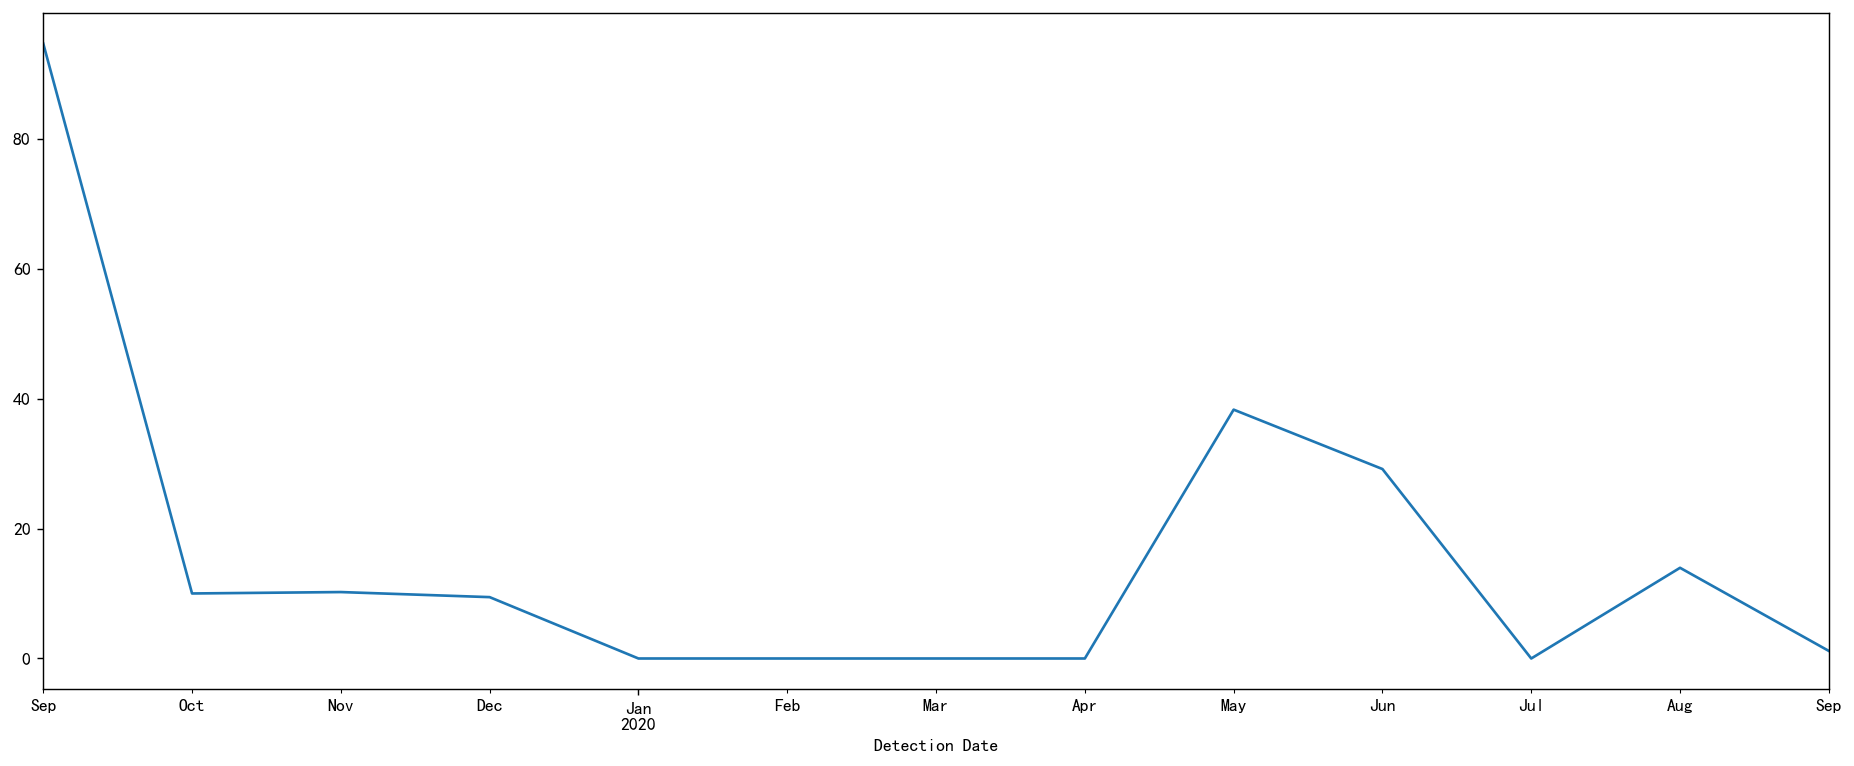

In [103]:
df_Month = data_distance.resample('M').sum()
plt.figure(figsize=(18, 7), dpi=128)
df_Month['Distance'].plot()

In [104]:
df_Month

,Distance,Detection Num,Date Normal,Close_diff_1,Close_diff_2,Close_diff_4,Close_diff_6,Close_diff_10
Detection Date,,,,,,,,
2019-09-30,94.7435,1474653.0,0.029101,-89.8593,0.0000,0.0000,0.0000,0.0000
2019-10-31,10.0177,737362.0,0.108466,7.5756,97.4349,0.0000,0.0000,0.0000
2019-11-30,10.2342,737376.0,0.145503,0.2165,-7.3591,0.0000,0.0000,0.0000
2019-12-31,9.4532,737401.0,0.211640,-0.7810,-0.9975,0.0000,0.0000,0.0000
2020-01-31,0.0000,0.0,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-02-29,0.0000,0.0,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-03-31,0.0000,0.0,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-04-30,0.0000,0.0,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000
2020-05-31,38.3378,1475132.0,1.296296,17.1628,15.6752,99.4465,0.0000,0.0000


In [95]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# lag_acf = acf(df_Month.values.reshape(-1).tolist(), nlags=20)
# lag_pacf = pacf(df_Month.values.reshape(-1).tolist(), nlags=20, method='ols')

# fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(data_distance, lags=100, ax=axes[0])
plot_pacf(data_distance, lags=100, ax=axes[1])
plt.show()

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [137]:
from statsmodels.tsa.arima_model import ARMA
from datetime import datetime
from itertools import product

# 设置p阶，q阶范围
# product p,q的所有组合
# 设置最好的aic为无穷大
# 对范围内的p,q阶进行模型训练，得到最优模型
ps = range(0,100)
qs = range(0,100)
parameters = product((ps, qs))

parameters_list = list(parameters)

df_Month = data_distance.resample('M').sum()
# plt.figure(figsize=(18, 7), dpi=128)
# df_Month['Distance'].plot()

best_aic = float('inf')
results = []
for param in parameters_list:
    try:
        model = ARMA(df_Month['Distance'], order=(param[0][0], param[0][1])).fit()
    except ValueError:
        print("参数错误：", param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = model.aic
        best_param = param
    results.append([param, model.aic])
results_table = pd.DataFrame(results)
results_table.columns = ['parameters', 'aic']
print("最优模型", best_model.summary())

最优模型                               ARMA Model Results                              
Dep. Variable:               Distance   No. Observations:                   13
Model:                     ARMA(0, 1)   Log Likelihood                 -60.544
Method:                       css-mle   S.D. of innovations             25.460
Date:                Sat, 06 Feb 2021   AIC                            127.087
Time:                        02:40:41   BIC                            128.782
Sample:                    09-30-2019   HQIC                           126.739
                         - 09-30-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             16.7671      8.817      1.902      0.057      -0.513      34.048
ma.L1.Distance     0.1716      0.688      0.249      0.803      -1.176       1.519
                               

In [138]:
# 先增加后几个月的时间日期，进行合并
date_list = [datetime(2021, 8, 31), datetime(2021, 9, 30), datetime(2021, 10, 31),
             datetime(2021, 11, 30), datetime(2021, 12, 31), 
             datetime(2022, 1, 31)]
df_Month = df_Month[['Distance']]
future = pd.DataFrame(index=date_list, columns= df_Month.columns)
df_Month = pd.concat([df_Month, future])
df_Month

,Distance
2019-09-30,94.7435
2019-10-31,10.0177
2019-11-30,10.2342
2019-12-31,9.4532
2020-01-31,0.0000
2020-02-29,0.0000
2020-03-31,0.0000
2020-04-30,0.0000
2020-05-31,38.3378
2020-06-30,29.1889


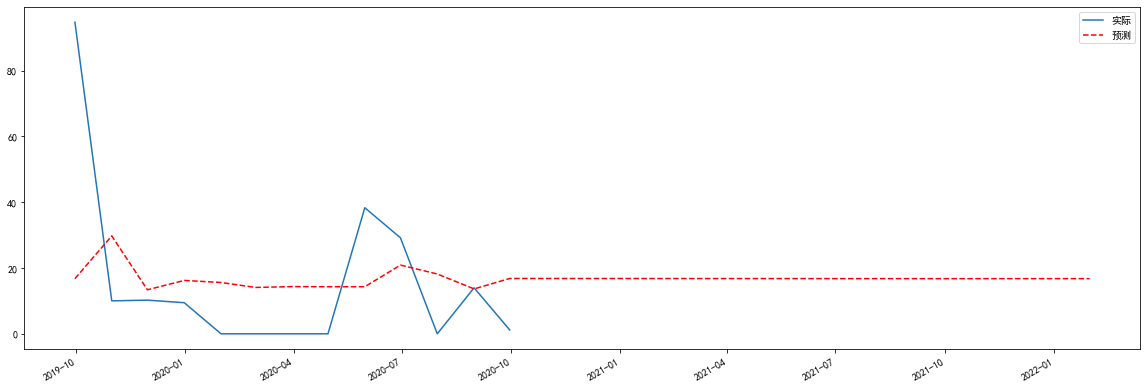

In [168]:
df_Month['forecast'] = best_model.predict(start = df_Month.index[0] ,end = df_Month.index[-1] )
plt.figure(figsize=(20, 7))
df_Month['Distance'].plot(label='实际')
df_Month['forecast'].plot(color='r', ls='--', label='预测')
plt.legend()
plt.show()

In [72]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

In [140]:
df_Month

,Distance,forecast
2019-09-30,94.7435,16.767070
2019-10-31,10.0177,29.762481
2019-11-30,10.2342,13.382433
2019-12-31,9.4532,16.226961
2020-01-31,0.0000,15.604940
2020-02-29,0.0000,14.089830
2020-03-31,0.0000,14.349768
2020-04-30,0.0000,14.305172
2020-05-31,38.3378,14.312823
2020-06-30,29.1889,20.888882


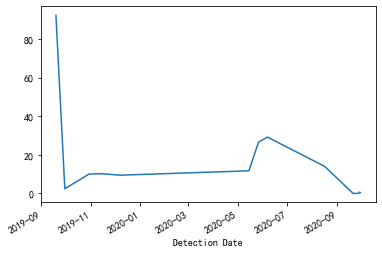

In [143]:
data_distance['Distance'].plot()

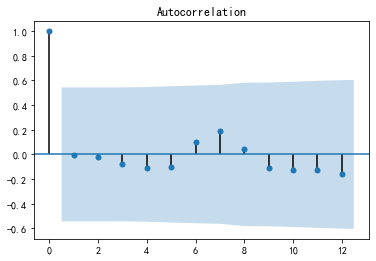

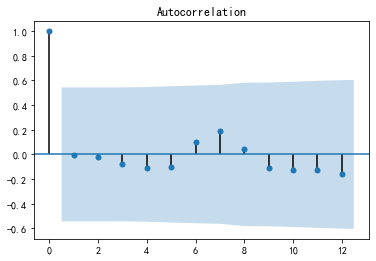

In [147]:
plot_acf(data_distance['Distance'])
#plt.savefig('acf.png')
#plot_pacf(data_distance['Distance'])

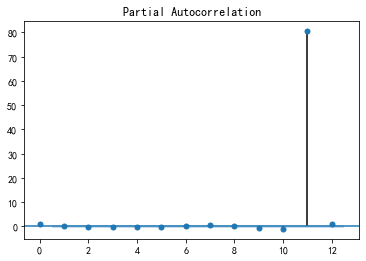

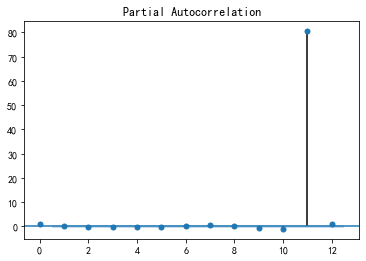

In [148]:
plot_pacf(data_distance['Distance'])

In [218]:
data_distance['Detection Date'] = pd.to_datetime(data_distance['Detection Date'])
data_distance.index = data_distance['Detection Date']
test = data_distance['Distance'].copy()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


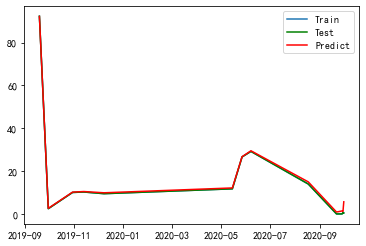

In [268]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# df = data_distance['Distance']
# df = df.resample('M')
#df.index.freq = 'M'
#train, test = df.iloc[:13, 0], df.iloc[13:, 0]
model = ExponentialSmoothing(data_distance['Distance'], seasonal='mul', seasonal_periods=12).fit()
# test = data_distance['Distance'].copy()
# test.index = date_list
pred = model.predict(start = test.index[0])

plt.plot(data_distance['Distance'].index, data_distance['Distance'], label='Train')
plt.plot(test.index, test, label='Test',c='g')
plt.plot(pred.index, pred, label='Predict',c='r')
plt.legend(loc='best')

In [256]:
test.index

DatetimeIndex(['2019-09-19', '2019-09-30', '2019-10-30', '2019-11-13',
               '2019-12-08', '2020-05-15', '2020-05-27', '2020-06-07',
               '2020-08-17', '2020-09-21', '2020-09-28', '2020-09-29',
               '2020-09-30'],
              dtype='datetime64[ns]', name='Detection Date', freq=None)

In [261]:
# 先增加后几个月的时间日期，进行合并
date_list = [datetime(2021, 1, 29), datetime(2021, 2, 28), datetime(2021, 3, 30),
             datetime(2021, 4, 30), datetime(2021, 5, 31), 
             datetime(2022, 6, 30), datetime(2022, 7, 31),datetime(2021, 8, 31), datetime(2021, 9, 30), datetime(2021, 10, 31),
             datetime(2021, 11, 30), datetime(2021, 12, 31), 
             datetime(2022, 1, 31)]
future = pd.DataFrame(data=date_list,columns=['Date'])
future['Date'] = pd.to_datetime(future['Date'])

test.index = future['Date']

In [265]:
test

Date
2021-01-29    92.3014
2021-02-28     2.4421
2021-03-30    10.0177
2021-04-30    10.2342
2021-05-31     9.4532
2022-06-30    11.7218
2022-07-31    26.6160
2021-08-31    29.1889
2021-09-30    13.9719
2021-10-31     0.0082
2021-11-30     0.0054
2021-12-31     0.7105
2022-01-31     0.4391
Name: Distance, dtype: float64

In [266]:
test.index = data_distance.index

In [196]:
from statsmodels.tsa.arima_model import ARIMA

#还原到原始序列：
#第一种情况，如果初始时序值不为0，则采用下面的方法：
#ts_restored = pd.Series([data[0]], index=[data.index[0]]).append(data1).cumsum()
#第二种情况，如果初始值为0，那么就直接把原始数据data带入第六步里面
ts_restored = data_distance['Distance']
#第六步：使用ARIMA模型进行预测
model = ARIMA(ts_restored,order=(7,0,1)) #第一种情况，导入ARIMA模型
#model = ARIMA(data,order=(7,1,0))   #第二种情况，导入ARIMA模型
result = model.fit(disp=-1)
#print(result.summary())
result.conf_int()#模型诊断，可以发现所有的系数置信区间都不为0；即在5%的置信水平下，所有的系数都是显著的，即模型通过检验。

#最后画出时序图
fig, ax = plt.subplots(figsize=(12, 10))
ax = ts_restored.loc[0:].plot(ax=ax)   #注意起点是从1901开始
fig = result.plot_predict(10, 10+len(ts_restored))  #因为前面是90个数，所以加上预测的10个就是100
plt.show()   #数据预测并画图

ValueError: The model specification cannot be estimated. The model contains 7 regressors (0 trend, 0 seasonal, 7 lags) but after adjustment for hold_back and creation of the lags, there are only 6 data points available to estimate parameters.